# 1. Практическое задание. Обучение полносвязной нейронной сети.



**ФИО**: Харская Стефания Андреенва



### Большая просьба



Называйте файл hw1_Фамилия.ipynb

In [1]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных (2 балла)

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.



В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Это не совсем про тексты, но зато он численный и его можно вытянуть в вектор. Это легко и полезно, чтобы отработать разные приемы. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)



test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

100%|██████████| 26421880/26421880 [00:10<00:00, 2411710.56it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208921.70it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3856645.15it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9283008.17it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [3]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [4]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.

Эти вспомогательные классы находятся в модуле `torch.utils.data`.



При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.



Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [5]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):

        ### YOUR CODE HERE
        ### LOAD IMAGES AND LABELS WITH FUNCTION
        kind = 'train' if train else 't10k'
        self.images, self.labels = load_mnist(path, kind)

        ### ALSO PROVIDE TRANSFORMS TO APPLY
        self.image_transform = image_transform
        self.label_transform = label_transform

    def __len__(self,):
        ### YOUR CODE
        # RETURN LENGTH OF DATASET
        return len(self.labels)

    def __getitem__(self, idx):
        ### YOUR CODE HERE
        ### APPLY TRANSFORMS AND RETURN ELEMENTS
        image = self.images[idx]
        label = self.labels[idx]
        image = image.astype(np.float32).reshape(28, 28)

        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label

In [6]:
test_dataset = FashionMnist("data/FashionMNIST/raw", train=False)
train_dataset = FashionMnist("data/FashionMNIST/raw")

Визуализируйте случайные элементы набора данных.

In [7]:
import random

In [8]:
### YOUR CODE HERE
def show_sample(dataset):
  index = random.randint(0, len(dataset) - 1)
  image, label = dataset[index]
  plt.imshow(image, cmap='GnBu')
  plt.title(f'Label: {label}')
  plt.show()

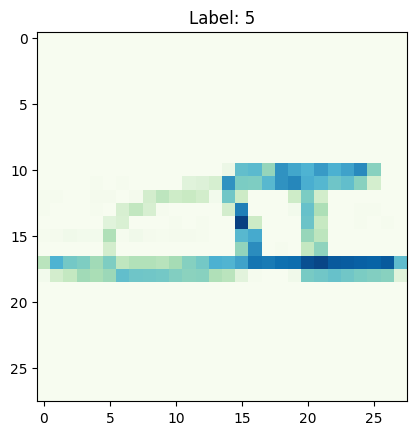

In [9]:
show_sample(train_dataset)

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`



Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [10]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        ### YOUR CODE HERE
        return torch.from_numpy(sample).float()

# SHOULD BE CALLABLE ToTensor()(x)

In [11]:
transform = ToTensor()
### YOUR CODE HERE
# init dataset with your transform and check datatype
transformed_dataset = FashionMnist("data/FashionMNIST/raw", image_transform=transform)
image, label = transformed_dataset[0]

In [12]:
image.dtype, image.shape

(torch.float32, torch.Size([28, 28]))

Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [13]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [14]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.



Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [15]:
### YOUR CODE HERE
### WRITE A COLLATE FUNCTION and use it with dataloaders
def collate_fn(batch):
    images = []
    labels = []

    for item in batch:
        image, label = item
        images.append(transform(image))
        labels.append(label)
        
    images = torch.stack(images)
    return images, labels

Убедитесть, что все работает корректно.

In [16]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True, collate_fn=collate_fn)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2, shuffle=True, collate_fn=collate_fn)
batch = next(iter(test_dataloader))

In [17]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


## 2. Реализация модулей нейронной сети (3 балла)



В этом разделе мы полностью реализуем модули для полносвязанной сети.



Для начала нам понадобится реализовать прямой и обратный проход через слои.



Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [18]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [19]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)



### 2.1 Функция активации ReLU

Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [20]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        ### YOUR CODE HERE
        ### CALCULATE RELU FUNCTION WITH TORCH AND SAVE SOMETHING FOR BACKWARD VIA CTX
        output = torch.max(input, torch.tensor(0.0)) #здесь применяем z = max(x, 0)
        ctx.save_for_backward(output) #здесь сохраняем
        return output

    @staticmethod
    def backward(ctx, grad_output):
        ### YOUR CODE HERE
        ### GET SOMETHING FROM FORWARD AND CALCULATE GRADIENT
        # CHECK LECTIONS OR GOOGLE

        output, = ctx.saved_tensors #здесь достаём
        out = (output >= 0).float() #здесь градиент, который получается только для положительных значений будет. У нас функция ReLU от 0 до бесконечности в положительную сторону.
        return grad_output * out

In [21]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = ReLUFunction.apply

    def forward(self, input):
        return self.relu(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [22]:
torch.manual_seed(0)

x = torch.rand((7,15), requires_grad = True, dtype=torch.double)
relu = ReLU()
assert gradcheck(relu, x)

In [23]:
torch_relu = torch.relu
our_relu = ReLU()

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)

Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [24]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):
        ### YOUR CODE HERE
        ### CALCULATE OUTPUT
        ### AND SAVE SOMETHING FOR BACKWARD
        inp = inp.double() #долго мучилась при обучении модели, что он ругается на типы double!=float
        weight = weight.double()
        bias = bias.double()
        output = inp @ weight.T + bias #вычисляю y = Wx+b
        ctx.save_for_backward(inp, weight, bias)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # GET SOMETHING FROM BACKWARD
        inp, weight, bias = ctx.saved_tensors

        # CHECK HOW BACKWARD PERFORMED
        grad_bias = grad_output.sum(0)
        grad_weight = grad_output.T @ inp
        grad_input = grad_output @ weight

        return grad_input, grad_weight, grad_bias


In [25]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()
        ### YOUR CODE HERE
        ### initialize weights and bias with small random numbers or xavier
        ### do not forget to make them torch.nn.Parameter
        self.weight = torch.nn.Parameter(torch.randn(output_units, input_units, dtype=torch.double) * 0.001) #должны быть маленькими, поэтому умножаю на 0.001
        self.bias = torch.nn.Parameter(torch.randn(output_units, dtype=torch.double) * 0.001)

        self.linear = LinearFunction.apply
        
    def forward(self,inp):
        return self.linear(inp, self.weight, self.bias)


Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [26]:
torch.manual_seed(0)

x = torch.rand((6,12), requires_grad = True, dtype=torch.double)
linear = Linear(12, 14)

assert gradcheck(linear, x)

Сравнение с `PyTorch`.

In [27]:
output_units = 32
input_units = 15

x = torch.rand((16,15), requires_grad = True, dtype=torch.double)

weight = torch.rand(size=(output_units, input_units), dtype=torch.double)
bias = torch.rand(size=(output_units,), dtype=torch.double)

torch_linear = torch.nn.Linear(input_units, output_units, dtype=torch.double)
our_linear = Linear(input_units, output_units)


state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)

torch_forward = torch_linear.forward(x)
our_forward = our_linear(x)
assert torch.allclose(torch_forward, our_forward)

## 3. Сборка и обучение нейронной сети (5 баллов)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

In [28]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        ### YOUR CODE HERE
        ### STACK LAYERS WITH DEFINED PARAMETERS
        ### USE nn.Dropout, your linear, your relu and whatever you like
        ### LAST LAYER SHOULD BE nn.LogSoftmax

        layers = [] #нам нужны слои, вот тут их будем хранить
        layers.append(torch.nn.Linear(input_size, hidden_layers_size)) #добавим первый полносвязный линейный слой
        layers.append(nn.BatchNorm1d(hidden_layers_size)) #Batch normalization. В тетрадках с семинаров нет, но на лекции было
        layers.append(torch.nn.ReLU()) #теперь нелинейности
        layers.append(torch.nn.Dropout(p=0.3))

        prev_dim = hidden_layers_size
        for _ in range(num_layers - 5): #5, так как есть 3 слоя до (Linear, BatchNorm1d, ReLU) и ещё два после будут (Linear, LogSoftmax)
          layers.append(torch.nn.Linear(prev_dim, hidden_layers_size))
          layers.append(nn.BatchNorm1d(hidden_layers_size))
          layers.append(torch.nn.ReLU())
          layers.append(torch.nn.Dropout(p=0.3))  #для регуляризации, вероятность p оставим по дефолту 0.5
          prev_dim = hidden_layers_size

        layers.append(nn.Linear(prev_dim, num_classes))
        layers.append(torch.nn.LogSoftmax(dim=1)) #последний слой по условию
        
        self.net = torch.nn.Sequential(*layers).double()  #объединяю

    def forward(self, inp):
        ### YOUR CODE HERE
        ### APPLY YOUR NET TO THE INPUT
        return self.net(inp)

Ниже вам предстоит написать цикл обучения. Сначала это бывает больно, но потом уже на автомате делается, в начале так всегда


In [29]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [30]:
# accuract metric for our classififcation
def accuracy(model_labels, labels):
  return torch.mean((model_labels == labels).float())

In [31]:
def perform_epoch(model, loader, criterion,
                optimizer=None, device=None):
    is_train = optimizer is not None
    ### YOUR CODE HERE
    ### MOVE MODEL TO DEVICE
    model.to(device)
    ### CHANGE MODEL TO TRAIN OR EVAL MODE
    if is_train:
        model.train()
    else:
        model.eval()

    ### SET LOGGING VALUES
    losses = []
    correct = 0
    total = 0
    
    ### ITERATE OVER DATALOADER
    for batch in loader:
      ### MOVE BATCH AND LABELS TO DEVICE
      inputs, labels = batch
      inputs = inputs.to(device).double()
      labels = torch.tensor(labels).to(device)

      ### GET MODEL OUTPUT
      labels_pred = model(inputs.view(-1, 28*28))

      ### GET MODEL PREDICTIONS (from the probabilites)
      probabilities = torch.exp(labels_pred) #так как последний LogSoftmax
      predicted = torch.argmax(probabilities, dim=1)

      ### CALCULATE LOSS
      loss = criterion(labels_pred, labels) #считаю лос

      ### BACKWARD IF TRAIN
      if is_train:
        ### STEP WITH OPTIMIZER (DONT FORGET TO ZERO GRAD)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ### UPDATE LOGGING VALUES WITH LOSS AND ACCURACY
    losses.append(loss.item())  #значение потерь
    correct += (predicted == labels).sum().item()  #правильные предсказания
    total += labels.size(0)  #общее количество

    ### RETURN LOGGED VALUES
    avg_loss = sum(losses) / len(losses) #средняя потеря
    accuracy = correct / total #точность

    return avg_loss, accuracy

Теперь обучим нашу нейронную сеть.

In [32]:
from tqdm import tqdm #Я не могу работать без progress bar. У меня всегда ощущение,
                      #что что-то случилось и ничего не работает. Прада что-то странно
                      #выводится, но это не столь важно для меня. Главное, чтобы был виден процесс

Комментарий от меня:





В самом первом блоке мы делим на тренировочные и тестовые данные. Валидационных нет. Я в начале добавила разделение и на валидационные в начало, но потом, когда я дошла уже до этого места, то поняла следующие:



На графики надо будет помещать тестовые данные. Однако тестовые всё-таки используются обычно для того, чтобы сказать финальную точность модели. У нас же такого в задании нет. Следовательно я сделала вывод, что если нам не нужна итоговая точность, то те тестовые данные = валидационные. Это, мне кажется не очень хорошей штукой. Всё-таки принято делить. С другой стороны, это же просто тренировка написания чего-то и прямо точность-точность нам не нужна, а важен процесс.



Просто хотела объяснить на всякий случай, как я поняла задание.

In [33]:
input_size = 28 * 28
hidden_layers_size = 32
num_layers = 5
num_classes = 10

# INIT YOUR MODEL
model = Network(input_size, hidden_layers_size, num_layers, num_classes)

# CRITERION
criterion = nn.CrossEntropyLoss()

#  AND OPTIMIZER
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Add device
device = torch.device('cuda:0')

# SET NUMBER OF EPOCHS
num_epochs = 10

# ITERATE OVER NUMBERS OF EPOCH
for epoch in tqdm(range(num_epochs)):
    # TRAIN AND VALIDATE
    train_loss, train_acc = perform_epoch(model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = perform_epoch(model, test_dataloader, criterion, device=device)

    # LOG METRICS FOR TRAIN AND VAL LIKE BELOW. (YOU MAY USE YOUR OWN WAY)
    print(f"Epoch - {epoch+1} : train loss {train_loss}, train accuracy {train_acc}, test loss {test_loss}, test accuracy {test_acc}")

 10%|█         | 1/10 [00:12<01:49, 12.18s/it]

Epoch - 1 : train loss 0.8751536119290751, train accuracy 0.5333333333333333, test loss 0.17366697487408692, test accuracy 0.9


 20%|██        | 2/10 [00:23<01:33, 11.73s/it]

Epoch - 2 : train loss 0.7472631647272343, train accuracy 0.6, test loss 0.543836441786826, test accuracy 0.7


 30%|███       | 3/10 [00:34<01:20, 11.55s/it]

Epoch - 3 : train loss 0.3934020328922804, train accuracy 0.8666666666666667, test loss 0.33472661294035577, test accuracy 0.8


 40%|████      | 4/10 [00:46<01:09, 11.57s/it]

Epoch - 4 : train loss 0.5283705772783692, train accuracy 0.7333333333333333, test loss 0.23178205947794658, test accuracy 1.0


 50%|█████     | 5/10 [00:57<00:57, 11.52s/it]

Epoch - 5 : train loss 0.24392522662929222, train accuracy 1.0, test loss 0.21277132124587866, test accuracy 1.0


 60%|██████    | 6/10 [01:09<00:45, 11.44s/it]

Epoch - 6 : train loss 0.7356688578853087, train accuracy 0.6666666666666666, test loss 0.2790340953449394, test accuracy 1.0


 70%|███████   | 7/10 [01:20<00:34, 11.49s/it]

Epoch - 7 : train loss 0.7500961032810676, train accuracy 0.6, test loss 0.4780978828204893, test accuracy 0.7


 80%|████████  | 8/10 [01:32<00:22, 11.44s/it]

Epoch - 8 : train loss 0.6262427117141708, train accuracy 0.7333333333333333, test loss 0.288024820595857, test accuracy 0.8


 90%|█████████ | 9/10 [01:43<00:11, 11.45s/it]

Epoch - 9 : train loss 0.15179643691066508, train accuracy 0.9333333333333333, test loss 0.16015981968286405, test accuracy 1.0


100%|██████████| 10/10 [01:54<00:00, 11.50s/it]

Epoch - 10 : train loss 0.5122298515473664, train accuracy 0.8, test loss 0.3098144164187289, test accuracy 0.9


Дальше:

- Проведите эксперименты с числом слоев.

- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.

- Сделайте выводы.



Мне показалось, что код предыдущей ячейки лучше чуть переписать для задания и как начало тестов обозначить здесь.

In [35]:
input_size = 28 * 28
hidden_layers_size = 32
layer_list = [5, 8, 10] #колиество слоёв, думаю для нашего эксперимента хватит 3 значений
num_classes = 10
num_epochs = 10

train_loss_all = [] #тут храню метрики для визуализации
test_loss_all = []
train_acc_all = []
test_acc_all = []

for num_layers in layer_list: #цикл экспериментов
  print(f"----- Количество слоёв {num_layers} ------")
  model = Network(input_size, hidden_layers_size, num_layers, num_classes)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  device = torch.device('cuda:0')

  train_loss_now = [] #тут храню метрики для текущей штуки
  test_loss_now = []
  train_acc_now = []
  test_acc_now = []

  for epoch in tqdm(range(num_epochs)):
      train_loss, train_acc = perform_epoch(model, train_dataloader, criterion, optimizer, device)
      test_loss, test_acc = perform_epoch(model, test_dataloader, criterion, device=device)

      train_loss_now.append(train_loss)
      test_loss_now.append(test_loss)
      train_acc_now.append(train_acc)
      test_acc_now.append(test_acc)

      print(f"Epoch - {epoch+1} : train loss {train_loss}, train accuracy {train_acc}, val loss {test_loss}, val accuracy {test_acc}")

  train_loss_all.append(train_loss_now)
  test_loss_all.append(test_loss_now)
  train_acc_all.append(train_acc_now)
  test_acc_all.append(test_acc_now)

----- Количество слоёв 5 ------


 10%|█         | 1/10 [00:11<01:45, 11.72s/it]

Epoch - 1 : train loss 1.231662780228429, train accuracy 0.7333333333333333, val loss 0.48014920415175694, val accuracy 0.8


 20%|██        | 2/10 [00:23<01:32, 11.62s/it]

Epoch - 2 : train loss 0.7090399624278582, train accuracy 0.8, val loss 0.3833860768806935, val accuracy 0.8


 30%|███       | 3/10 [00:34<01:20, 11.46s/it]

Epoch - 3 : train loss 0.6111383577831935, train accuracy 0.7333333333333333, val loss 0.40396111162892323, val accuracy 0.8


 40%|████      | 4/10 [00:46<01:09, 11.51s/it]

Epoch - 4 : train loss 0.5705021022284992, train accuracy 0.8, val loss 0.18509558340700968, val accuracy 1.0


 50%|█████     | 5/10 [00:57<00:57, 11.43s/it]

Epoch - 5 : train loss 0.9017573606462224, train accuracy 0.6, val loss 0.3005280611799947, val accuracy 0.9


 60%|██████    | 6/10 [01:08<00:45, 11.43s/it]

Epoch - 6 : train loss 0.4651589037671214, train accuracy 0.8666666666666667, val loss 0.17322681469026524, val accuracy 0.9


 70%|███████   | 7/10 [01:20<00:34, 11.49s/it]

Epoch - 7 : train loss 0.5727622492233151, train accuracy 0.8, val loss 0.5397071624994207, val accuracy 0.6


 80%|████████  | 8/10 [01:31<00:22, 11.46s/it]

Epoch - 8 : train loss 0.794970453247388, train accuracy 0.7333333333333333, val loss 0.46452695255401305, val accuracy 0.8


 90%|█████████ | 9/10 [01:43<00:11, 11.47s/it]

Epoch - 9 : train loss 0.37472297450370173, train accuracy 0.8666666666666667, val loss 0.3427310747209306, val accuracy 0.8


100%|██████████| 10/10 [01:54<00:00, 11.47s/it]


Epoch - 10 : train loss 0.1736100216930084, train accuracy 0.9333333333333333, val loss 0.49974793826920116, val accuracy 0.8
----- Количество слоёв 8 ------


 10%|█         | 1/10 [00:17<02:37, 17.51s/it]

Epoch - 1 : train loss 0.9391666943855127, train accuracy 0.6, val loss 0.530443848441653, val accuracy 0.8


 20%|██        | 2/10 [00:35<02:20, 17.56s/it]

Epoch - 2 : train loss 0.5218646379742228, train accuracy 0.8666666666666667, val loss 0.4600085765698233, val accuracy 0.9


 30%|███       | 3/10 [00:52<02:01, 17.35s/it]

Epoch - 3 : train loss 0.6262216718801152, train accuracy 0.7333333333333333, val loss 0.36993891856762884, val accuracy 0.8


 40%|████      | 4/10 [01:09<01:44, 17.39s/it]

Epoch - 4 : train loss 0.28952862863305096, train accuracy 0.9333333333333333, val loss 0.7530056804790164, val accuracy 0.7


 50%|█████     | 5/10 [01:27<01:27, 17.41s/it]

Epoch - 5 : train loss 0.5200387962522512, train accuracy 0.8, val loss 0.516115628445676, val accuracy 0.8


 60%|██████    | 6/10 [01:44<01:09, 17.42s/it]

Epoch - 6 : train loss 0.4104551610765884, train accuracy 0.9333333333333333, val loss 0.5705925263038001, val accuracy 0.8


 70%|███████   | 7/10 [02:01<00:52, 17.42s/it]

Epoch - 7 : train loss 0.38175297641904643, train accuracy 0.8666666666666667, val loss 0.6297682177453687, val accuracy 0.7


 80%|████████  | 8/10 [02:19<00:34, 17.33s/it]

Epoch - 8 : train loss 0.92523867154348, train accuracy 0.6, val loss 0.7417336951768889, val accuracy 0.7


 90%|█████████ | 9/10 [02:36<00:17, 17.30s/it]

Epoch - 9 : train loss 0.5305745324001628, train accuracy 0.8666666666666667, val loss 0.5945021004519153, val accuracy 0.8


100%|██████████| 10/10 [02:53<00:00, 17.36s/it]


Epoch - 10 : train loss 0.6894191181747021, train accuracy 0.8, val loss 0.4959615713699176, val accuracy 0.8
----- Количество слоёв 10 ------


 10%|█         | 1/10 [00:21<03:12, 21.36s/it]

Epoch - 1 : train loss 1.2857967158974943, train accuracy 0.4, val loss 0.6382133426756119, val accuracy 0.8


 20%|██        | 2/10 [00:42<02:50, 21.29s/it]

Epoch - 2 : train loss 1.451743691805052, train accuracy 0.5333333333333333, val loss 0.5214506683240598, val accuracy 0.8


 30%|███       | 3/10 [01:03<02:27, 21.11s/it]

Epoch - 3 : train loss 0.9716102353579218, train accuracy 0.5333333333333333, val loss 0.8506422752780571, val accuracy 0.7


 40%|████      | 4/10 [01:24<02:06, 21.05s/it]

Epoch - 4 : train loss 0.7890407419914318, train accuracy 0.6666666666666666, val loss 0.45703840968660464, val accuracy 0.7


 50%|█████     | 5/10 [01:45<01:45, 21.07s/it]

Epoch - 5 : train loss 1.1549486765182684, train accuracy 0.5333333333333333, val loss 0.7942470479383749, val accuracy 0.6


 60%|██████    | 6/10 [02:06<01:24, 21.00s/it]

Epoch - 6 : train loss 0.6482651711587265, train accuracy 0.7333333333333333, val loss 0.6951612728162744, val accuracy 0.6


 70%|███████   | 7/10 [02:27<01:03, 21.12s/it]

Epoch - 7 : train loss 0.7213150412223043, train accuracy 0.8666666666666667, val loss 0.728098188281934, val accuracy 0.6


 80%|████████  | 8/10 [02:49<00:42, 21.16s/it]

Epoch - 8 : train loss 1.1597191834173703, train accuracy 0.5333333333333333, val loss 0.92058449646339, val accuracy 0.7


 90%|█████████ | 9/10 [03:09<00:20, 20.99s/it]

Epoch - 9 : train loss 0.9556795235359175, train accuracy 0.6666666666666666, val loss 0.3390211518624459, val accuracy 0.9


100%|██████████| 10/10 [03:30<00:00, 21.07s/it]

Epoch - 10 : train loss 0.8396672527644656, train accuracy 0.6, val loss 0.3453962198700789, val accuracy 1.0


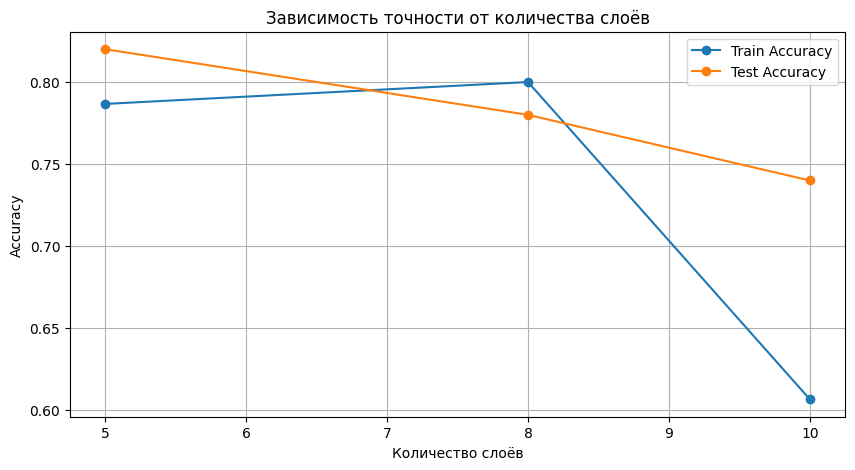

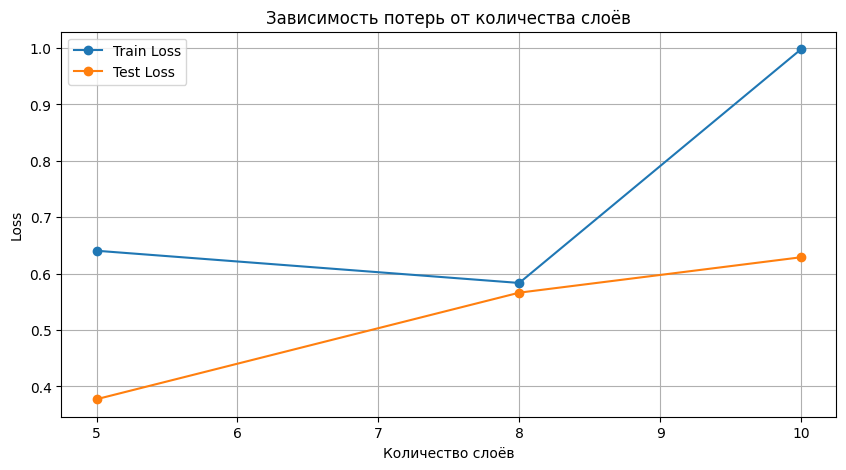

In [36]:
avg_train_acc = [sum(acc_list) / len(acc_list) for acc_list in train_acc_all]
avg_test_acc = [sum(acc_list) / len(acc_list) for acc_list in test_acc_all]

avg_train_loss = [sum(loss_list) / len(loss_list) for loss_list in train_loss_all]
avg_test_loss = [sum(loss_list) / len(loss_list) for loss_list in test_loss_all]

#для точности
plt.figure(figsize=(10, 5))
plt.plot(layer_list, avg_train_acc, label="Train Accuracy", marker='o')
plt.plot(layer_list, avg_test_acc, label="Test Accuracy", marker='o')
plt.xlabel("Количество слоёв")
plt.ylabel("Accuracy")
plt.title("Зависимость точности от количества слоёв")
plt.legend()
plt.grid(True)
plt.show()

#для потерь
plt.figure(figsize=(10, 5))
plt.plot(layer_list, avg_train_loss, label="Train Loss", marker='o')
plt.plot(layer_list, avg_test_loss, label="Test Loss", marker='o')
plt.xlabel("Количество слоёв")
plt.ylabel("Loss")
plt.title("Зависимость потерь от количества слоёв")
plt.legend()
plt.grid(True)
plt.show()

# Эксперимент и первые выводы:

Хорошие результаты, я не думала, что такая достаточно высокая точность будет. Первая версия нейросети у меня была без BatchNorm1d и результаты были меньше 0.4. Однако всё равно есть небольшой минус: видна тенденция к переобучению. С количеством слоёв падает точность и увеличивается loss. 

Удивительно, но на тесте значениу на 5 и 10 слоях лучше. Только на 8 слоях тренировочная точность оказывается лучше. Я думала, что везде тренировочная будет выше.

Лучший результат у модели с 5 слоями. Возможно, стоит как-то с Dropout поэксперементировать, чтобы не было переобучения.

Теперь ещё дважды повторим.

In [41]:
input_size = 28 * 28
hidden_layers_size = 32
layer_list = [5, 8, 10] #колиество слоёв, думаю для нашего эксперимента хватит 4 значений
num_classes = 10
num_epochs = 10

train_loss_all = [] #тут храню метрики для визуализации
test_loss_all = []
train_acc_all = []
test_acc_all = []

for num_layers in layer_list: #цикл экспериментов
  print(f"----- Количество слоёв {num_layers} ------")
  model = Network(input_size, hidden_layers_size, num_layers, num_classes)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  device = torch.device('cuda:0')

  train_loss_now = [] #тут храню метрики для текущей штуки
  test_loss_now = []
  train_acc_now = []
  test_acc_now = []

  for epoch in tqdm(range(num_epochs)):
      train_loss, train_acc = perform_epoch(model, train_dataloader, criterion, optimizer, device)
      test_loss, test_acc = perform_epoch(model, test_dataloader, criterion, device=device)

      train_loss_now.append(train_loss)
      test_loss_now.append(test_loss)
      train_acc_now.append(train_acc)
      test_acc_now.append(test_acc)
      
      print(f"Epoch - {epoch+1} : train loss {train_loss}, train accuracy {train_acc}, val loss {test_loss}, val accuracy {test_acc}")

  train_loss_all.append(train_loss_now)
  test_loss_all.append(test_loss_now)
  train_acc_all.append(train_acc_now)
  test_acc_all.append(test_acc_now)

----- Количество слоёв 5 ------


 10%|█         | 1/10 [00:11<01:44, 11.58s/it]

Epoch - 1 : train loss 0.639250431432751, train accuracy 0.6666666666666666, val loss 0.24430453429481921, val accuracy 0.9


 20%|██        | 2/10 [00:23<01:33, 11.63s/it]

Epoch - 2 : train loss 0.6948294796827744, train accuracy 0.7333333333333333, val loss 0.7637340767212669, val accuracy 0.6


 30%|███       | 3/10 [00:34<01:21, 11.64s/it]

Epoch - 3 : train loss 0.6745345487002117, train accuracy 0.6666666666666666, val loss 0.3517614676911016, val accuracy 0.8


 40%|████      | 4/10 [00:46<01:09, 11.60s/it]

Epoch - 4 : train loss 0.5206597069925816, train accuracy 0.8, val loss 0.3634197461743996, val accuracy 0.8


 50%|█████     | 5/10 [00:57<00:57, 11.52s/it]

Epoch - 5 : train loss 0.30503568727780084, train accuracy 0.9333333333333333, val loss 0.6961763191684989, val accuracy 0.7


 60%|██████    | 6/10 [01:09<00:46, 11.50s/it]

Epoch - 6 : train loss 0.2738715595034893, train accuracy 0.8666666666666667, val loss 0.9316196790667568, val accuracy 0.6


 70%|███████   | 7/10 [01:20<00:34, 11.47s/it]

Epoch - 7 : train loss 0.30831955477807405, train accuracy 0.8666666666666667, val loss 0.3591363798975185, val accuracy 0.9


 80%|████████  | 8/10 [01:32<00:23, 11.50s/it]

Epoch - 8 : train loss 0.5605070076688674, train accuracy 0.8, val loss 0.37422236072294446, val accuracy 0.7


 90%|█████████ | 9/10 [01:43<00:11, 11.43s/it]

Epoch - 9 : train loss 0.665347835918604, train accuracy 0.9333333333333333, val loss 0.39240057856806243, val accuracy 0.8


100%|██████████| 10/10 [01:54<00:00, 11.50s/it]


Epoch - 10 : train loss 0.5131237277002342, train accuracy 0.8, val loss 0.0929887512268177, val accuracy 1.0
----- Количество слоёв 8 ------


 10%|█         | 1/10 [00:17<02:39, 17.68s/it]

Epoch - 1 : train loss 0.6041162017134131, train accuracy 0.8, val loss 0.5506429907951762, val accuracy 0.8


 20%|██        | 2/10 [00:34<02:18, 17.29s/it]

Epoch - 2 : train loss 1.0447210837981205, train accuracy 0.6666666666666666, val loss 0.2558141704783628, val accuracy 0.9


 30%|███       | 3/10 [00:52<02:01, 17.35s/it]

Epoch - 3 : train loss 0.7623604216048668, train accuracy 0.7333333333333333, val loss 0.15203965704765507, val accuracy 1.0


 40%|████      | 4/10 [01:09<01:44, 17.34s/it]

Epoch - 4 : train loss 0.7858704067821198, train accuracy 0.7333333333333333, val loss 0.3033211040778808, val accuracy 1.0


 50%|█████     | 5/10 [01:26<01:26, 17.22s/it]

Epoch - 5 : train loss 0.8910045449512208, train accuracy 0.7333333333333333, val loss 0.3399653112058568, val accuracy 0.9


 60%|██████    | 6/10 [01:43<01:08, 17.22s/it]

Epoch - 6 : train loss 0.6780788167609947, train accuracy 0.7333333333333333, val loss 0.7408021487064416, val accuracy 0.8


 70%|███████   | 7/10 [02:00<00:51, 17.10s/it]

Epoch - 7 : train loss 0.7984622713481511, train accuracy 0.7333333333333333, val loss 0.433698956934752, val accuracy 0.8


 80%|████████  | 8/10 [02:17<00:34, 17.14s/it]

Epoch - 8 : train loss 1.7645329918010786, train accuracy 0.4666666666666667, val loss 0.4491833937118062, val accuracy 0.9


 90%|█████████ | 9/10 [02:34<00:17, 17.09s/it]

Epoch - 9 : train loss 0.7760308138596782, train accuracy 0.7333333333333333, val loss 0.6971091398743476, val accuracy 0.7


100%|██████████| 10/10 [02:51<00:00, 17.18s/it]


Epoch - 10 : train loss 0.9827918948365517, train accuracy 0.7333333333333333, val loss 0.18516432457532295, val accuracy 1.0
----- Количество слоёв 10 ------


 10%|█         | 1/10 [00:20<03:08, 20.94s/it]

Epoch - 1 : train loss 1.030095260063239, train accuracy 0.7333333333333333, val loss 0.8654814542951307, val accuracy 0.8


 20%|██        | 2/10 [00:41<02:47, 20.97s/it]

Epoch - 2 : train loss 0.897719261733181, train accuracy 0.8, val loss 0.9217983136986645, val accuracy 0.7


 30%|███       | 3/10 [01:02<02:26, 20.99s/it]

Epoch - 3 : train loss 0.9878611830921122, train accuracy 0.6, val loss 0.41240509069804326, val accuracy 0.9


 40%|████      | 4/10 [01:23<02:05, 20.86s/it]

Epoch - 4 : train loss 1.0008617213597197, train accuracy 0.6, val loss 0.8189870084623283, val accuracy 0.6


 50%|█████     | 5/10 [01:44<01:44, 20.84s/it]

Epoch - 5 : train loss 0.5333040690563962, train accuracy 0.8666666666666667, val loss 0.7280589755085174, val accuracy 0.7


 60%|██████    | 6/10 [02:05<01:23, 20.86s/it]

Epoch - 6 : train loss 0.8504298612465171, train accuracy 0.6666666666666666, val loss 0.5855938025941075, val accuracy 0.8


 70%|███████   | 7/10 [02:25<01:02, 20.79s/it]

Epoch - 7 : train loss 0.3233084720642863, train accuracy 0.8666666666666667, val loss 0.9196193419163186, val accuracy 0.6


 80%|████████  | 8/10 [02:47<00:41, 20.91s/it]

Epoch - 8 : train loss 0.5611149241117916, train accuracy 0.9333333333333333, val loss 0.7669006020870904, val accuracy 0.8


 90%|█████████ | 9/10 [03:08<00:21, 21.07s/it]

Epoch - 9 : train loss 1.1747877511010747, train accuracy 0.6, val loss 1.4152059238337078, val accuracy 0.5


100%|██████████| 10/10 [03:29<00:00, 20.92s/it]

Epoch - 10 : train loss 1.732604607873474, train accuracy 0.4666666666666667, val loss 0.851968315516177, val accuracy 0.6


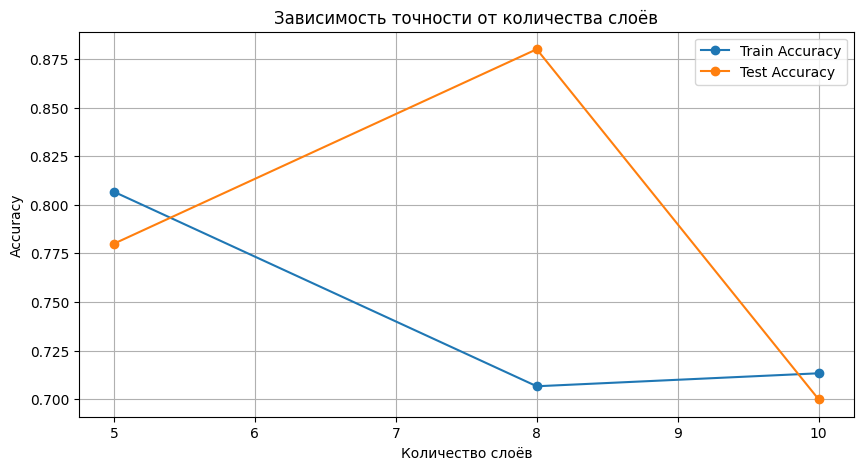

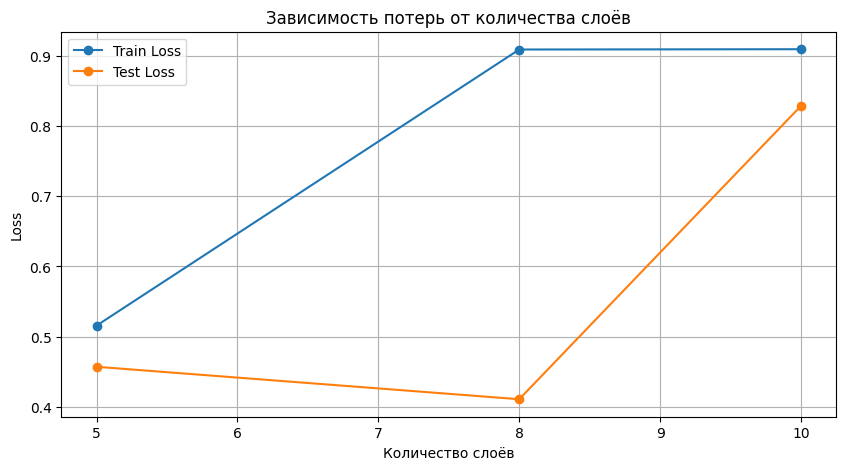

In [42]:
avg_train_acc = [sum(acc_list) / len(acc_list) for acc_list in train_acc_all]
avg_test_acc = [sum(acc_list) / len(acc_list) for acc_list in test_acc_all]

avg_train_loss = [sum(loss_list) / len(loss_list) for loss_list in train_loss_all]

avg_test_loss = [sum(loss_list) / len(loss_list) for loss_list in test_loss_all]


plt.figure(figsize=(10, 5))
plt.plot(layer_list, avg_train_acc, label="Train Accuracy", marker='o')
plt.plot(layer_list, avg_test_acc, label="Test Accuracy", marker='o')
plt.xlabel("Количество слоёв")
plt.ylabel("Accuracy")
plt.title("Зависимость точности от количества слоёв")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(layer_list, avg_train_loss, label="Train Loss", marker='o')
plt.plot(layer_list, avg_test_loss, label="Test Loss", marker='o')
plt.xlabel("Количество слоёв")
plt.ylabel("Loss")
plt.title("Зависимость потерь от количества слоёв")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
input_size = 28 * 28
hidden_layers_size = 32
layer_list = [5, 8, 10] #количество слоёв, думаю для нашего эксперимента хватит 4 значений
num_classes = 10
num_epochs = 10

train_loss_all = [] #тут хранб метрики для визуализации
test_loss_all = []
train_acc_all = []
test_acc_all = []

for num_layers in layer_list: #цикл экспериментов
  print(f"----- Количество слоёв {num_layers} ------")
  model = Network(input_size, hidden_layers_size, num_layers, num_classes)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  device = torch.device('cuda:0')

  train_loss_now = [] #тут храню метрики для текущей штуки
  test_loss_now = []
  train_acc_now = []
  test_acc_now = []

  for epoch in tqdm(range(num_epochs)):
      train_loss, train_acc = perform_epoch(model, train_dataloader, criterion, optimizer, device)
      test_loss, test_acc = perform_epoch(model, test_dataloader, criterion, device=device)

      train_loss_now.append(train_loss)
      test_loss_now.append(test_loss)
      train_acc_now.append(train_acc)
      test_acc_now.append(test_acc)

      print(f"Epoch - {epoch+1} : train loss {train_loss}, train accuracy {train_acc}, val loss {test_loss}, val accuracy {test_acc}")

  train_loss_all.append(train_loss_now)
  test_loss_all.append(test_loss_now)
  train_acc_all.append(train_acc_now)
  test_acc_all.append(test_acc_now)

----- Количество слоёв 5 ------


 10%|█         | 1/10 [00:11<01:40, 11.22s/it]

Epoch - 1 : train loss 0.14580878965093286, train accuracy 0.9333333333333333, val loss 0.47455953757721386, val accuracy 0.8


 20%|██        | 2/10 [00:22<01:30, 11.36s/it]

Epoch - 2 : train loss 0.6474042763026995, train accuracy 0.7333333333333333, val loss 0.3677323610497966, val accuracy 0.8


 30%|███       | 3/10 [00:34<01:19, 11.38s/it]

Epoch - 3 : train loss 0.384863794688881, train accuracy 0.8666666666666667, val loss 0.3867017400412759, val accuracy 0.8


 40%|████      | 4/10 [00:45<01:08, 11.34s/it]

Epoch - 4 : train loss 0.22905359761503125, train accuracy 1.0, val loss 0.40275276165774904, val accuracy 0.8


 50%|█████     | 5/10 [00:56<00:56, 11.29s/it]

Epoch - 5 : train loss 0.5070613910938079, train accuracy 0.9333333333333333, val loss 0.5679205206847532, val accuracy 0.9


 60%|██████    | 6/10 [01:08<00:45, 11.40s/it]

Epoch - 6 : train loss 0.25118137851694783, train accuracy 0.9333333333333333, val loss 0.2790203490402864, val accuracy 0.9


 70%|███████   | 7/10 [01:19<00:34, 11.35s/it]

Epoch - 7 : train loss 0.2207736827225004, train accuracy 0.9333333333333333, val loss 0.13938812127784667, val accuracy 1.0


 80%|████████  | 8/10 [01:30<00:22, 11.38s/it]

Epoch - 8 : train loss 0.32598670635097066, train accuracy 0.8666666666666667, val loss 0.3133649175992792, val accuracy 0.9


 90%|█████████ | 9/10 [01:42<00:11, 11.37s/it]

Epoch - 9 : train loss 1.3583996457846481, train accuracy 0.6666666666666666, val loss 0.3251604367627273, val accuracy 0.9


100%|██████████| 10/10 [01:53<00:00, 11.37s/it]


Epoch - 10 : train loss 0.7079364820777043, train accuracy 0.7333333333333333, val loss 0.14861629584222877, val accuracy 0.9
----- Количество слоёв 8 ------


 10%|█         | 1/10 [00:16<02:32, 16.93s/it]

Epoch - 1 : train loss 0.9501973895200256, train accuracy 0.7333333333333333, val loss 0.47124615761679955, val accuracy 0.8


 20%|██        | 2/10 [00:33<02:15, 16.98s/it]

Epoch - 2 : train loss 0.9010247844260745, train accuracy 0.7333333333333333, val loss 0.6750077794352891, val accuracy 0.8


 30%|███       | 3/10 [00:51<01:59, 17.04s/it]

Epoch - 3 : train loss 0.8756564609463663, train accuracy 0.7333333333333333, val loss 1.0202784865674401, val accuracy 0.6


 40%|████      | 4/10 [01:08<01:43, 17.18s/it]

Epoch - 4 : train loss 0.9495246603610069, train accuracy 0.8, val loss 0.6271581788822355, val accuracy 0.8


 50%|█████     | 5/10 [01:25<01:25, 17.14s/it]

Epoch - 5 : train loss 0.6568258029671121, train accuracy 0.7333333333333333, val loss 0.5692903415384661, val accuracy 0.9


 60%|██████    | 6/10 [01:42<01:08, 17.13s/it]

Epoch - 6 : train loss 0.7323904703101111, train accuracy 0.7333333333333333, val loss 0.8138861646005002, val accuracy 0.7


 70%|███████   | 7/10 [01:59<00:51, 17.09s/it]

Epoch - 7 : train loss 0.7937161988655739, train accuracy 0.6, val loss 0.7107225720746341, val accuracy 0.7


 80%|████████  | 8/10 [02:16<00:34, 17.14s/it]

Epoch - 8 : train loss 0.6000561726313454, train accuracy 0.8, val loss 0.19197573327661757, val accuracy 1.0


 90%|█████████ | 9/10 [02:34<00:17, 17.17s/it]

Epoch - 9 : train loss 0.573415391291734, train accuracy 0.8666666666666667, val loss 0.3689349931002725, val accuracy 0.9


100%|██████████| 10/10 [02:51<00:00, 17.12s/it]


Epoch - 10 : train loss 0.5626229049965418, train accuracy 0.8, val loss 0.3460079797270044, val accuracy 0.8
----- Количество слоёв 10 ------


 10%|█         | 1/10 [00:20<03:07, 20.89s/it]

Epoch - 1 : train loss 0.7812423375822041, train accuracy 0.5333333333333333, val loss 0.9726884924290996, val accuracy 0.5


 20%|██        | 2/10 [00:41<02:46, 20.87s/it]

Epoch - 2 : train loss 1.0257507564623072, train accuracy 0.6, val loss 0.5356325729782015, val accuracy 0.7


 30%|███       | 3/10 [01:02<02:26, 20.90s/it]

Epoch - 3 : train loss 0.7246274842301546, train accuracy 0.7333333333333333, val loss 0.7569804691919506, val accuracy 0.8


 40%|████      | 4/10 [01:23<02:05, 20.84s/it]

Epoch - 4 : train loss 0.759968973244111, train accuracy 0.8666666666666667, val loss 1.2563392587634095, val accuracy 0.5


 50%|█████     | 5/10 [01:44<01:44, 20.87s/it]

Epoch - 5 : train loss 0.9784218734982967, train accuracy 0.6666666666666666, val loss 0.7903586374442433, val accuracy 0.7


 60%|██████    | 6/10 [02:05<01:23, 20.92s/it]

Epoch - 6 : train loss 0.7755118708421703, train accuracy 0.8, val loss 0.45983960842966154, val accuracy 0.9


 70%|███████   | 7/10 [02:26<01:02, 20.86s/it]

Epoch - 7 : train loss 1.1729096816500924, train accuracy 0.4666666666666667, val loss 0.8073421713007619, val accuracy 0.6


 80%|████████  | 8/10 [02:46<00:41, 20.83s/it]

Epoch - 8 : train loss 1.6959582533208613, train accuracy 0.6, val loss 0.5461067166162872, val accuracy 0.8


 90%|█████████ | 9/10 [03:07<00:20, 20.81s/it]

Epoch - 9 : train loss 1.6127784791645292, train accuracy 0.4666666666666667, val loss 0.3724418279561811, val accuracy 0.9


100%|██████████| 10/10 [03:28<00:00, 20.86s/it]

Epoch - 10 : train loss 0.8948743689862926, train accuracy 0.6666666666666666, val loss 0.5749367515172255, val accuracy 0.8


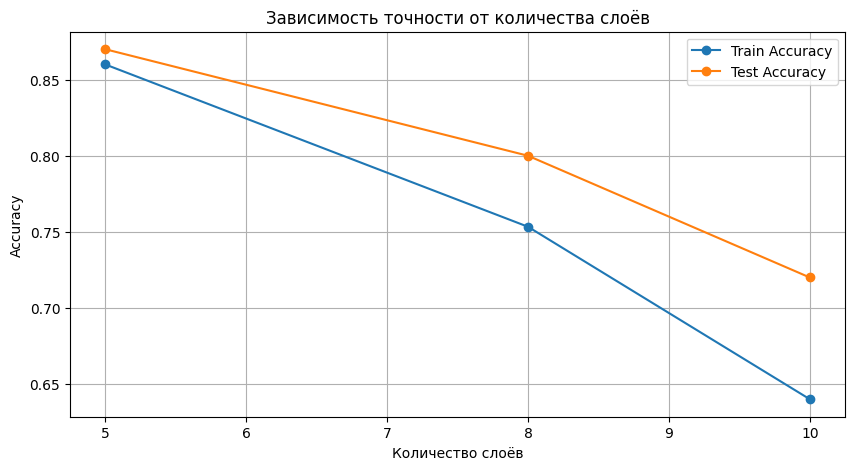

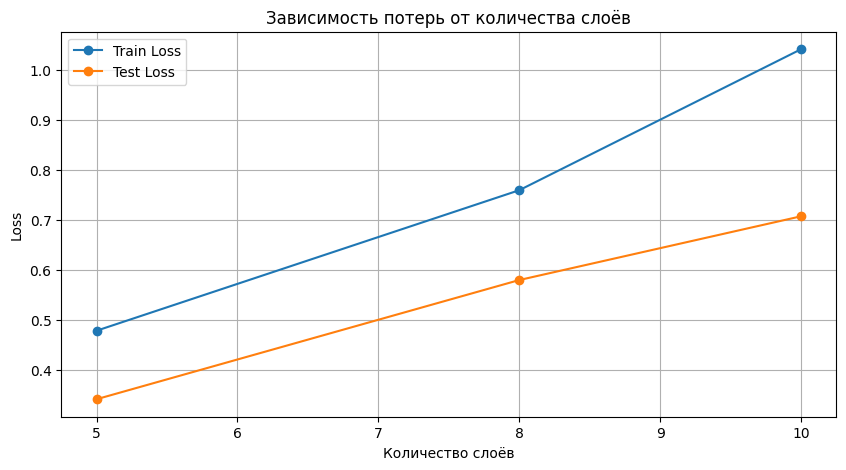

In [46]:
avg_train_acc = [sum(acc_list) / len(acc_list) for acc_list in train_acc_all]
avg_test_acc = [sum(acc_list) / len(acc_list) for acc_list in test_acc_all]

avg_train_loss = [sum(loss_list) / len(loss_list) for loss_list in train_loss_all]
avg_test_loss = [sum(loss_list) / len(loss_list) for loss_list in test_loss_all]

plt.figure(figsize=(10, 5))
plt.plot(layer_list, avg_train_acc, label="Train Accuracy", marker='o')
plt.plot(layer_list, avg_test_acc, label="Test Accuracy", marker='o')
plt.xlabel("Количество слоёв")
plt.ylabel("Accuracy")
plt.title("Зависимость точности от количества слоёв")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(layer_list, avg_train_loss, label="Train Loss", marker='o')
plt.plot(layer_list, avg_test_loss, label="Test Loss", marker='o')
plt.xlabel("Количество слоёв")
plt.ylabel("Loss")
plt.title("Зависимость потерь от количества слоёв")
plt.legend()
plt.grid(True)
plt.show()

В целом, результаты аналогичные

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (1 балл).

Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam.



**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание.

In [ ]:
class SotaOptimizer(Optimizer):

    def __init__(self, params, lr=1e-3):

        defaults = dict(lr=lr)

        super(SotaOptimizer, self).__init__(params, defaults)



    def __setstate__(self, state):

        super(SotaOptimizer, self).__setstate__(state)



    @torch.no_grad()

    def step(self,):



        for group in self.param_groups:

            lr = group['lr']

            for p in group['params']:

                if p.grad is not None:

                    p.data.add_(-lr*p.grad)

### 4.2 Реализация современной функции активации (1 балл).

Реализуйте одну из современных функций активации. Например, `Hardswish` или `GELU`. Сравните сеть с вашей активацией и с `ReLU`.



**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание.